In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline


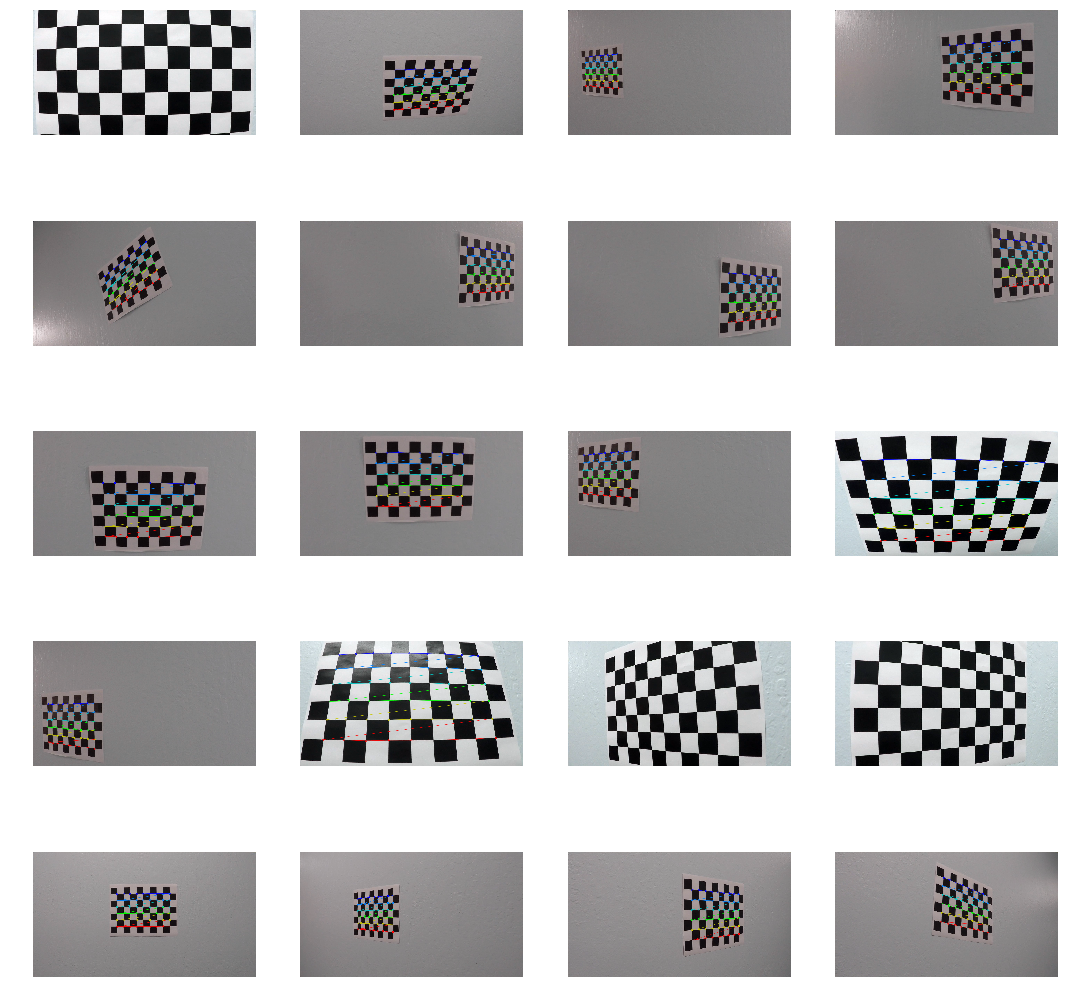

In [2]:

images = glob.glob('./camera_cal/calibration*.jpg')


objpoints = []
imgpoints = []
nx = 9
ny = 6
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

fig, axes = plt.subplots(5,4, figsize=(15,15))
axes = np.ravel(axes)

for n, fname in enumerate(images):
    cal_img = cv2.imread(fname)
    gray_cal_img = cv2.cvtColor(cal_img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray_cal_img, (nx, ny), None)
    axes[n].axis('off')
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        cv2.drawChessboardCorners(cal_img, (nx, ny), corners, ret)
    axes[n].imshow(cal_img)

fig.tight_layout()



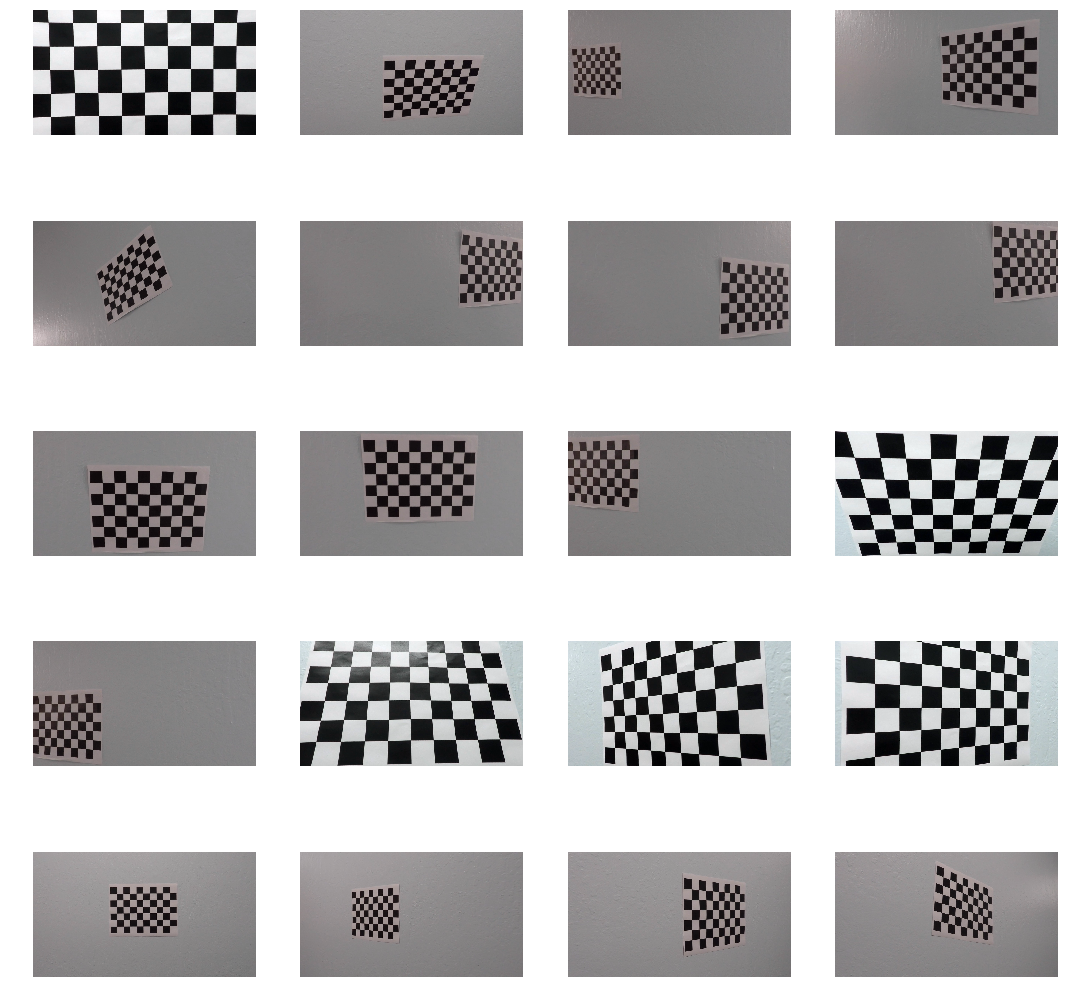

In [3]:

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray_cal_img.shape[::-1], None, None)

fig, axes = plt.subplots(5,4, figsize=(15,15))
axes = np.ravel(axes)

for n, fname in enumerate(images):
    cal_img = cv2.imread(fname)
    dst = cv2.undistort(cal_img, mtx, dist, None, mtx)
    axes[n].axis('off')
    axes[n].imshow(dst)

fig.tight_layout()

In [4]:

def warp(img):

    img_size = (img.shape[1], img.shape[0])	
    src = np.float32([[579,460],
                      [705,460],
                      [270,675],
                      [1045,675]])

    dst = np.float32([[300, 0],
                      [img.shape[1]-300,0],
                      [300,img.shape[0]],
                      [img.shape[1]-300,img.shape[0]]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)

    return warped, M, Minv

In [5]:

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):

	if orient is 'x':
		sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
	elif orient is 'y':
		sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
	abs_sobel = np.absolute(sobel)
	scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
	grad_binary = np.zeros_like(scaled_sobel)
	grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

	return grad_binary

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
	sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
	sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
	sobel_mag = np.sqrt(np.square(sobelx) + np.square(sobely))
	scaled_sobel_mag = np.uint8(255*sobel_mag/np.max(sobel_mag))
	grad_binary = np.zeros_like(scaled_sobel_mag)
	grad_binary[(scaled_sobel_mag >= thresh[0]) & (scaled_sobel_mag <= thresh[1])] = 1

	return grad_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
	sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
	sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
	abs_sobelx = np.absolute(sobelx)
	abs_sobely = np.absolute(sobely)
	sobel_angle = np.arctan2(abs_sobely, abs_sobelx)
	grad_binary = np.zeros_like(sobel_angle)
	grad_binary[(sobel_angle >= thresh[0]) & (sobel_angle <= thresh[1])] = 1

	return grad_binary

def hls_threshold(hls, channel='s', thresh=(0,255)):
	if channel is 'h':
		x = hls[:,:,0]
	elif channel is 'l':
		x = hls[:,:,1]
	elif channel is 's':
		x = hls[:,:,2]
	binary_output = np.zeros_like(x)
	binary_output[(x >= thresh[0]) & (x <= thresh[1])] = 1
	return binary_output

def rgb_threshold(rgb, channel='r', thresh=(0,255)):
	if channel is 'r':
		x = rgb[:,:,0]
	elif channel is 'g':
		x = rgb[:,:,1]
	elif channel is 'b':
		x = rgb[:,:,2]
	binary_output = np.zeros_like(x)
	binary_output[(x >= thresh[0]) & (x <= thresh[1])] = 1
	return binary_output

In [6]:
def line_fit_lane(binary_warped):

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return out_img, left_fitx, right_fitx, ploty, left_fit, right_fit




In [7]:

def line_fit_lane_from_prev(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result, left_fitx, right_fitx, ploty, left_fit, right_fit


In [8]:
# ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
# quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# # For each y position generate random x position within +/-50 pix
# # of the line base position in each case (x=200 for left, and x=900 for right)
# leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
#                               for y in ploty])
# rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
#                                 for y in ploty])

# leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
# rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# # Fit a second order polynomial to pixel positions in each fake lane line
# left_fit = np.polyfit(ploty, leftx, 2)
# left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
# right_fit = np.polyfit(ploty, rightx, 2)
# right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# # Plot up the fake data
# mark_size = 3
# plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
# plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
# plt.xlim(0, 1280)
# plt.ylim(0, 720)
# plt.plot(left_fitx, ploty, color='green', linewidth=3)
# plt.plot(right_fitx, ploty, color='green', linewidth=3)
# plt.gca().invert_yaxis() # to visualize as we do the images

# # Define y-value where we want radius of curvature
# # I'll choose the maximum y-value, corresponding to the bottom of the image
# y_eval = np.max(ploty)
# left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
# right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
# print(left_curverad, right_curverad)
# # Example values: 1926.74 1908.48


# # Define conversions in x and y from pixels space to meters
# ym_per_pix = 30/720 # meters per pixel in y dimension
# xm_per_pix = 3.7/700 # meters per pixel in x dimension

# # Fit new polynomials to x,y in world space
# left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
# right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# # Calculate the new radii of curvature
# left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
# right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# # Now our radius of curvature is in meters
# print(left_curverad, 'm', right_curverad, 'm')
# # Example values: 632.1 m    626.2 m

In [9]:

def draw_line_on_image(binary_warped, undist_img, Minv, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist_img.shape[1], undist_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    
    return result


In [10]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [11]:
def find_lane_pipeline(img):

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_hls = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HLS)
    
    undist_img = cv2.undistort(img_rgb, mtx, dist, None, mtx)
    
    gray_img = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)

    sxbinary = abs_sobel_thresh(gray_img, orient='x', sobel_kernel=3, thresh=(20, 100))
    rthresh_binary = rgb_threshold(img_rgb, channel='r', thresh=(220,255))
    gthresh_binary = rgb_threshold(img_rgb, channel='g', thresh=(200,255))
    sthresh_binary = hls_threshold(img_hls, channel='s', thresh=(200,255))
    
    combined_binary = np.zeros_like(sxbinary)
#     combined_binary[(sxbinary == 1) | (rthresh_binary == 1) | (gthresh_binary == 1) | (sthresh_binary == 1) ] = 1
    combined_binary[(rthresh_binary == 1) | (gthresh_binary == 1) | (sthresh_binary == 1) ] = 1

    binary_warped, M, Minv  = warp(combined_binary)
    
    if not l_Line.detected and not r_Line.detected:
        line_fit_img, left_fitx, right_fitx, ploty, left_fit, right_fit = line_fit_lane(binary_warped)
        l_Line.detected = True
        r_Line.detected = True
        l_Line.current_fit = left_fit
        r_Line.current_fit = right_fit
    else:
        line_fit_img, left_fitx, right_fitx, ploty, left_fit, right_fit = line_fit_lane(binary_warped)
#         line_fit_img, left_fitx, right_fitx, ploty, left_fit, right_fit = line_fit_lane_from_prev(binary_warped, l_Line.current_fit, r_Line.current_fit)
        l_Line.current_fit = left_fit
        r_Line.current_fit = right_fit
        
    
    img_with_lane = draw_line_on_image(binary_warped, undist_img, Minv, left_fitx, right_fitx, ploty)
    
    img_with_lane = cv2.cvtColor(img_with_lane, cv2.COLOR_RGB2BGR)

    return img_with_lane, binary_warped, line_fit_img

    
    
    
    

In [12]:
def process_image(image):
    
    result, binary_warped, line_fit_img = find_lane_pipeline(image)

    return result

In [13]:
def debug_frame(image_fname):

    test_img = cv2.imread(image_fname)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    test_img_hls = cv2.cvtColor(test_img, cv2.COLOR_RGB2HLS)

    fig, axes = plt.subplots(2,2, figsize=(35,18))
    axes = np.ravel(axes)

    axes[0].imshow(test_img)
    axes[0].axis('off')
    axes[0].set_title('Original image')

    undist_test_img = cv2.undistort(test_img, mtx, dist, None, mtx)
    axes[1].imshow(undist_test_img)
    axes[1].axis('off')
    axes[1].set_title('Undistroted image')


    axes[2].imshow(test_img)
    axes[2].axis('off')
    axes[2].set_title('Perspective transform points')
    axes[2].plot(579,460, '.')
    axes[2].plot(705,460, '.')
    axes[2].plot(270,675, '.')
    axes[2].plot(1045,675, '.')

    warped_img, M, Minv = warp(test_img)
    axes[3].imshow(warped_img)
    axes[3].axis('off')
    axes[3].set_title('Warped image')


    fig.tight_layout()
    


    fig, axes = plt.subplots(2,2, figsize=(35,18))
    axes = np.ravel(axes)

    gray_test_img = cv2.cvtColor(undist_test_img, cv2.COLOR_RGB2GRAY)


    sxbinary = abs_sobel_thresh(gray_test_img, orient='x', sobel_kernel=3, thresh=(20, 100))
    sybinary = abs_sobel_thresh(gray_test_img, orient='y', sobel_kernel=3, thresh=(20, 100))
    smagbinary = mag_thresh(gray_test_img, sobel_kernel=3, thresh=(20, 100))
    sanglebinary = dir_threshold(gray_test_img, sobel_kernel=3, thresh=(0.7, 1.3))


    axes[0].imshow(sxbinary, cmap='gray')
    axes[0].axis('off')
    axes[0].set_title('Sobel x')

    axes[1].imshow(sybinary, cmap='gray')
    axes[1].axis('off')
    axes[1].set_title('Sobel y')

    axes[2].imshow(smagbinary, cmap='gray')
    axes[2].axis('off')
    axes[2].set_title('Sobel mag')

    axes[3].imshow(sanglebinary, cmap='gray')
    axes[3].axis('off')
    axes[3].set_title('Sobel angle')


    fig.tight_layout()
    
    fig, axes = plt.subplots(2,3, figsize=(35,18))
    axes = np.ravel(axes)

    axes[0].imshow(test_img[:,:,0], cmap='gray')
    axes[0].axis('off')
    axes[0].set_title('R channel')
    axes[1].imshow(test_img[:,:,1], cmap='gray')
    axes[1].axis('off')
    axes[1].set_title('G channel')
    axes[2].imshow(test_img[:,:,2], cmap='gray')
    axes[2].axis('off')
    axes[2].set_title('B channel')
    axes[3].imshow(test_img_hls[:,:,0], cmap='gray')
    axes[3].axis('off')
    axes[3].set_title('H channel')
    axes[4].imshow(test_img_hls[:,:,1], cmap='gray')
    axes[4].axis('off')
    axes[4].set_title('L channel')
    axes[5].imshow(test_img_hls[:,:,2], cmap='gray')
    axes[5].axis('off')
    axes[5].set_title('S channel')

    fig.tight_layout()

    rthresh_binary = rgb_threshold(test_img, channel='r', thresh=(220,255))
    gthresh_binary = rgb_threshold(test_img, channel='g', thresh=(200,255))
    bthresh_binary = rgb_threshold(test_img, channel='b', thresh=(200,255))

    hthresh_binary = hls_threshold(test_img_hls, channel='h', thresh=(0,50))
    lthresh_binary = hls_threshold(test_img_hls, channel='l', thresh=(200,255))
    sthresh_binary = hls_threshold(test_img_hls, channel='s', thresh=(200,255))


    fig, axes = plt.subplots(2,3, figsize=(35,18))
    axes = np.ravel(axes)

    axes[0].imshow(rthresh_binary, cmap='gray')
    axes[0].axis('off')
    axes[0].set_title('R channel')
    axes[1].imshow(gthresh_binary, cmap='gray')
    axes[1].axis('off')
    axes[1].set_title('G channel')
    axes[2].imshow(bthresh_binary, cmap='gray')
    axes[2].axis('off')
    axes[2].set_title('B channel')
    axes[3].imshow(hthresh_binary, cmap='gray')
    axes[3].axis('off')
    axes[3].set_title('H channel')
    axes[4].imshow(lthresh_binary, cmap='gray')
    axes[4].axis('off')
    axes[4].set_title('L channel')
    axes[5].imshow(sthresh_binary, cmap='gray')
    axes[5].axis('off')
    axes[5].set_title('S channel')

    fig.tight_layout()


    combined_binary = np.zeros_like(sxbinary)
#     combined_binary[(sxbinary == 1) | (rthresh_binary == 1) | (gthresh_binary == 1) | (sthresh_binary == 1) ] = 1
    combined_binary[(rthresh_binary == 1) | (gthresh_binary == 1) | (sthresh_binary == 1) ] = 1

    fig, axes = plt.subplots()
    axes.imshow(combined_binary, cmap='gray')
    axes.axis('off')
    axes.set_title('Combined threshold')

    binary_warped, M, Minv  = warp(combined_binary)


    fig, axes = plt.subplots()
    axes.imshow(binary_warped, cmap='gray')
    axes.axis('off')
    axes.set_title('Combined threshold + Perspective transform')

    img = binary_warped
    plt.figure()
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    plt.plot(histogram)
    
    out_img, left_fitx, right_fitx, ploty, left_fit, right_fit = line_fit_lane(binary_warped)
    plt.figure()
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)


    

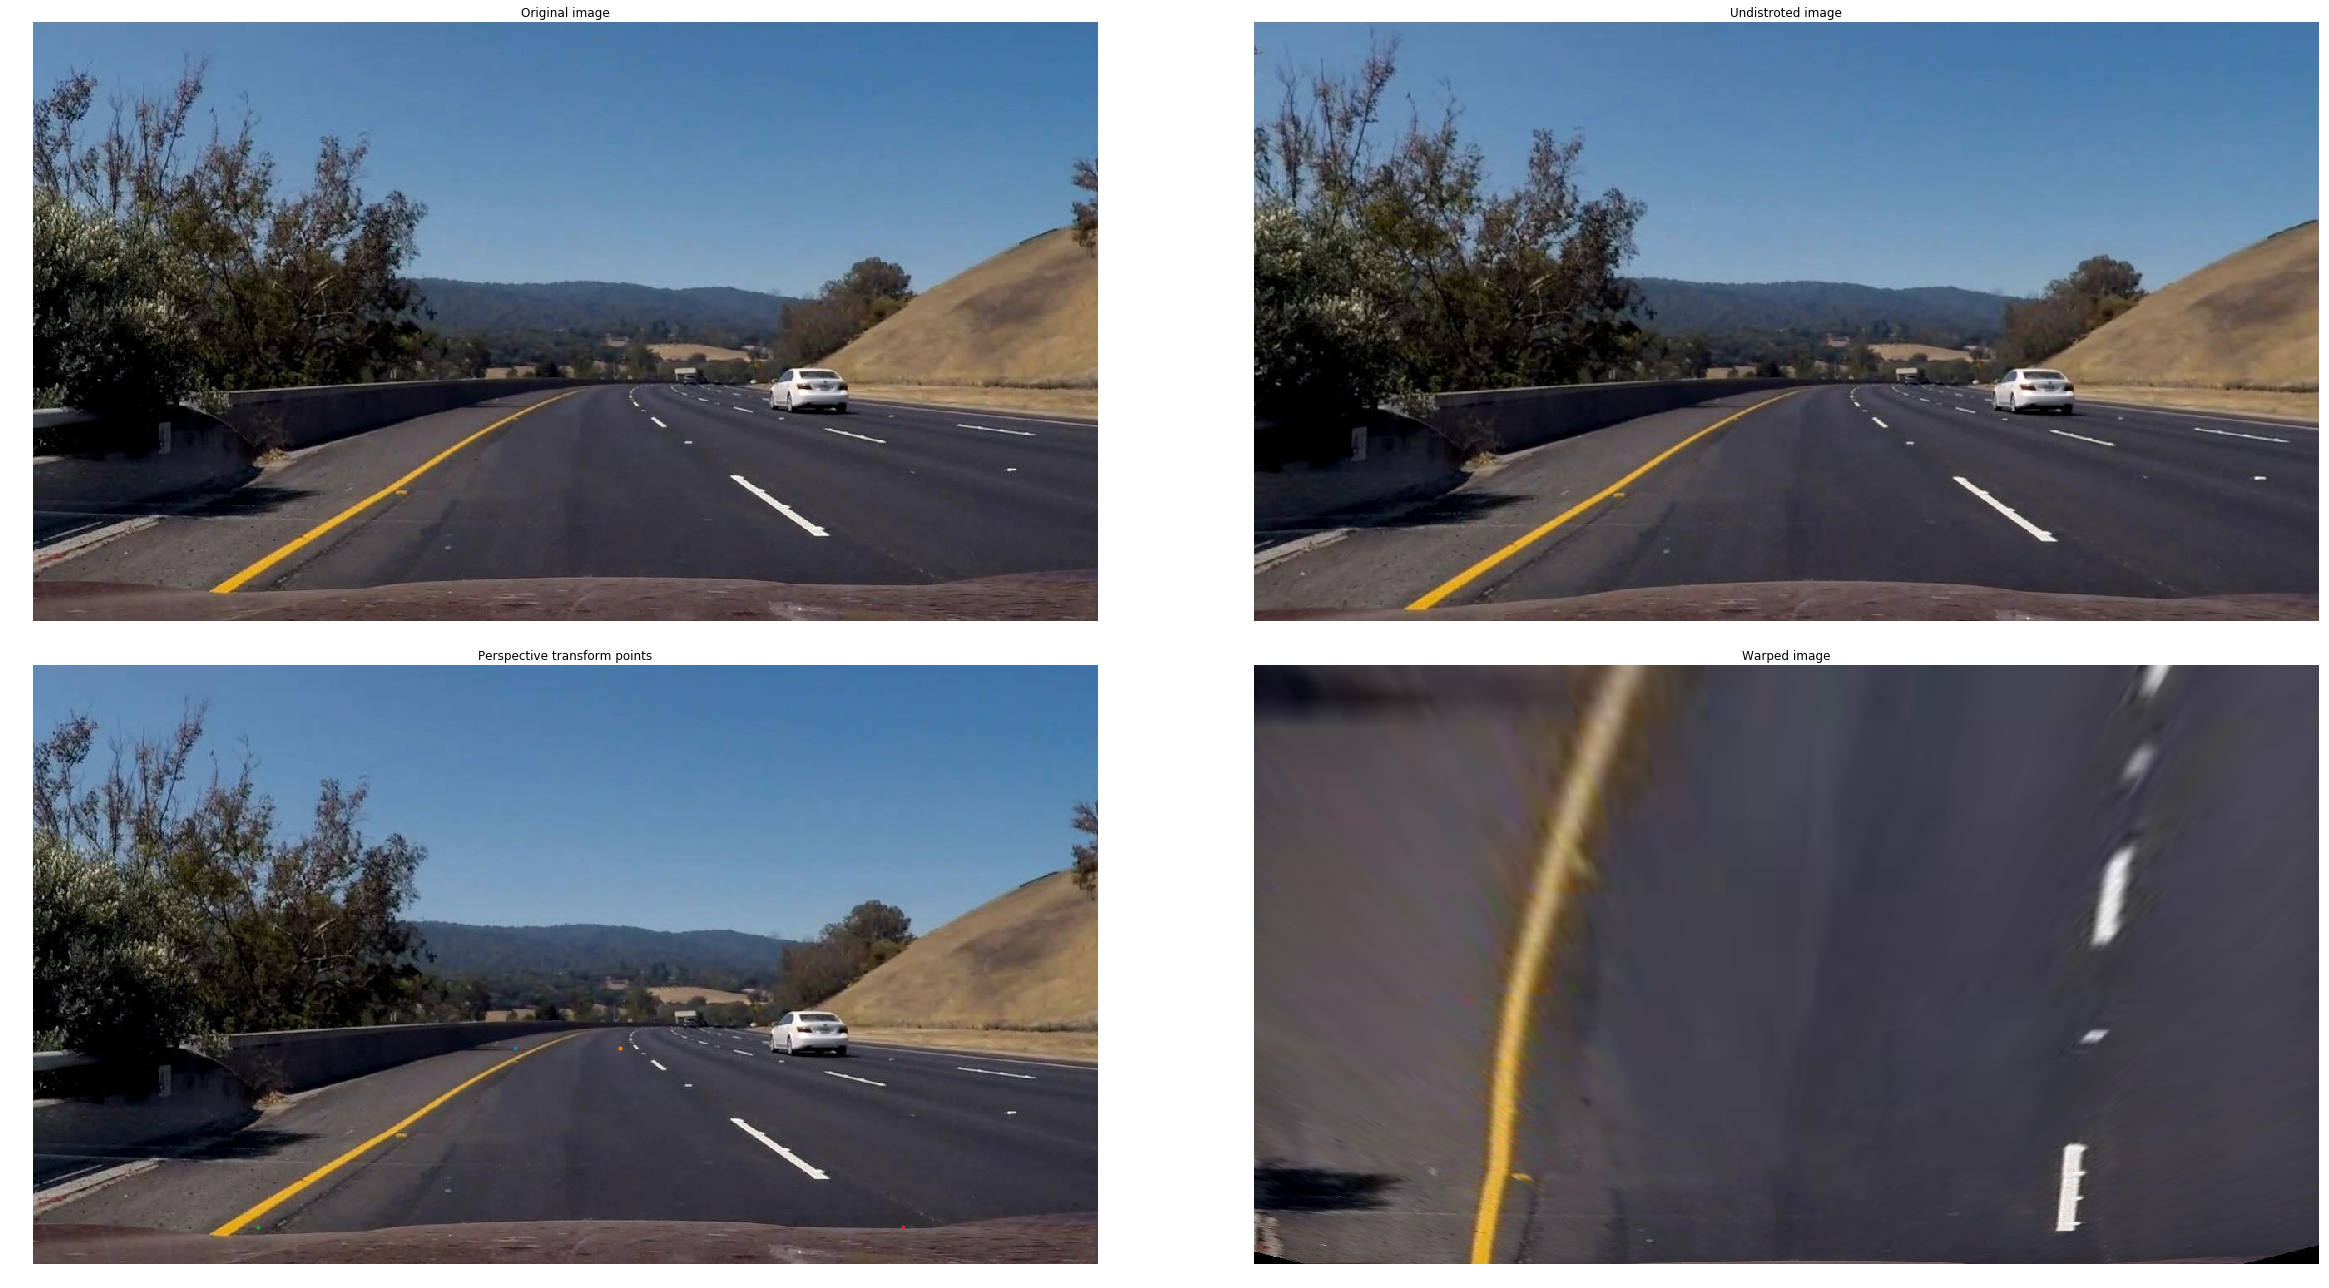

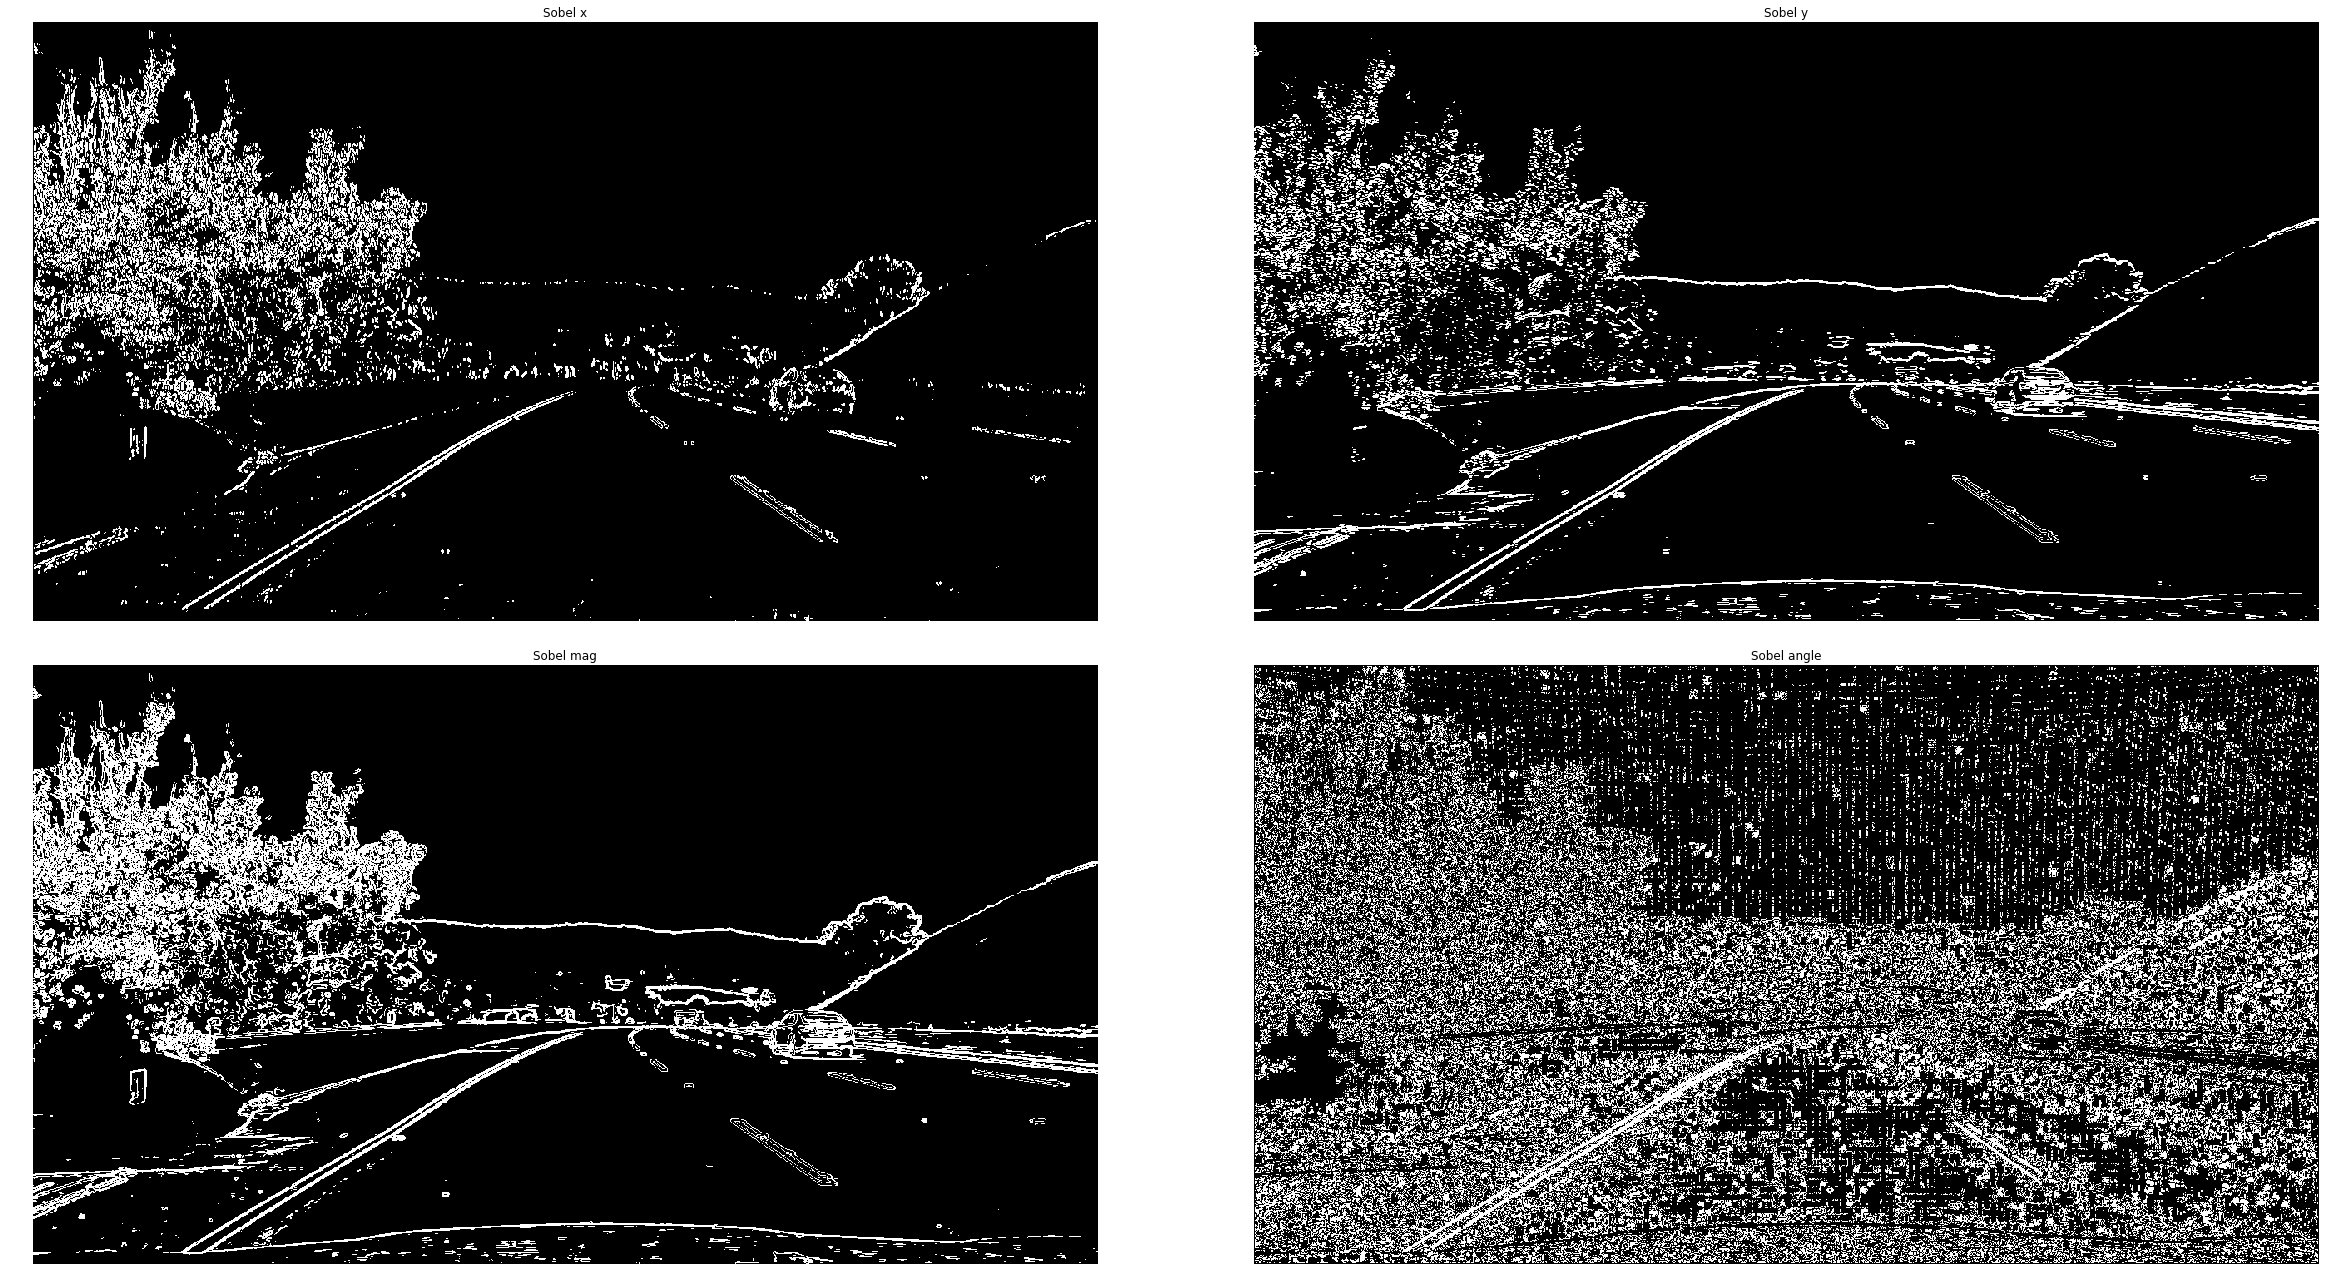

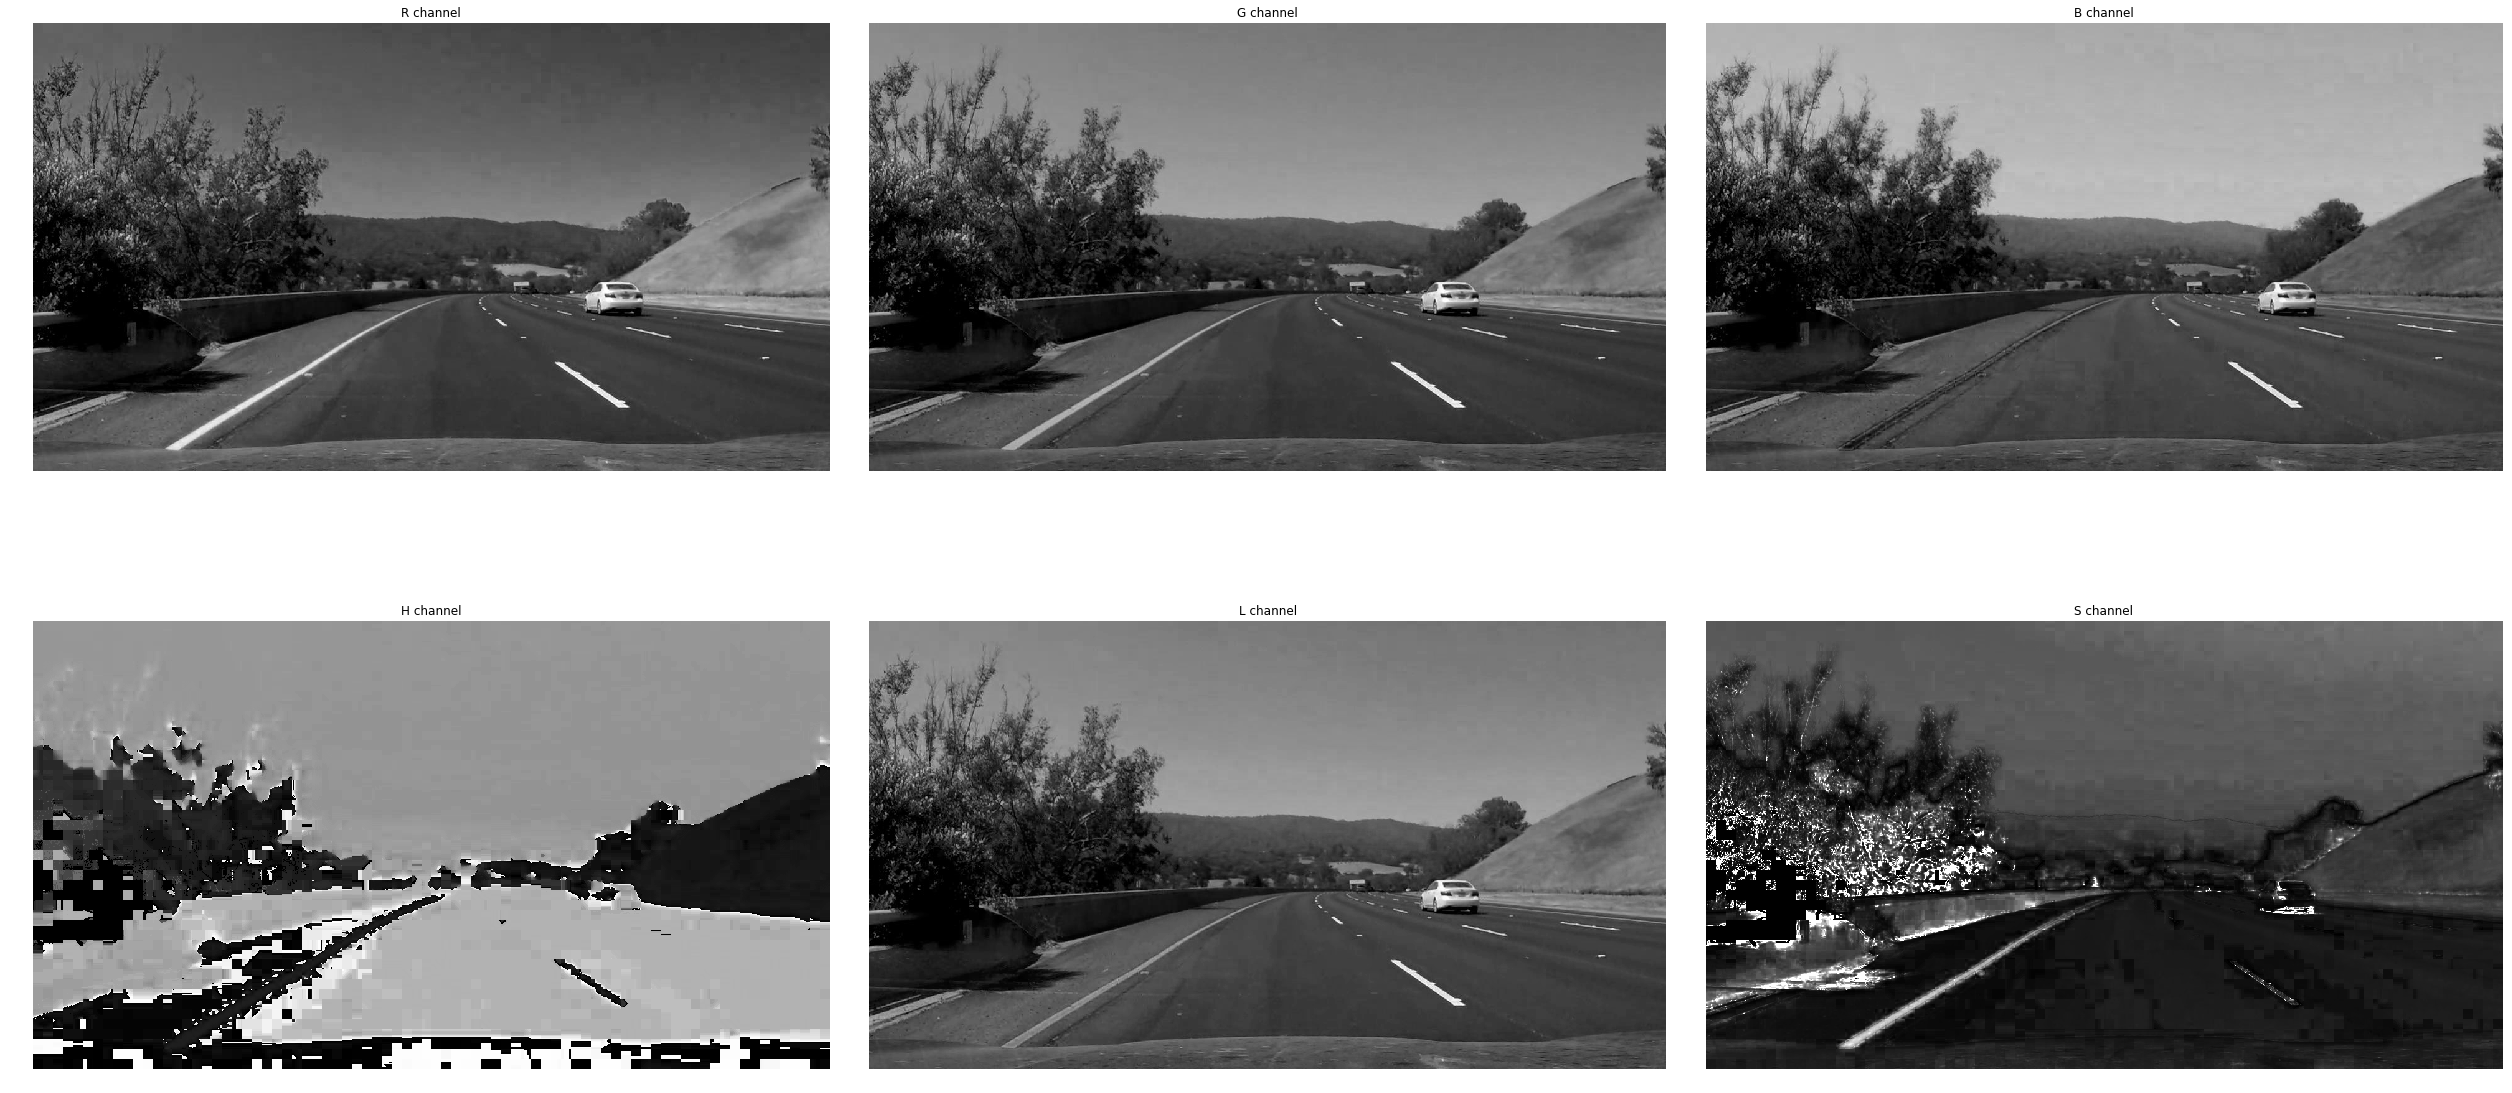

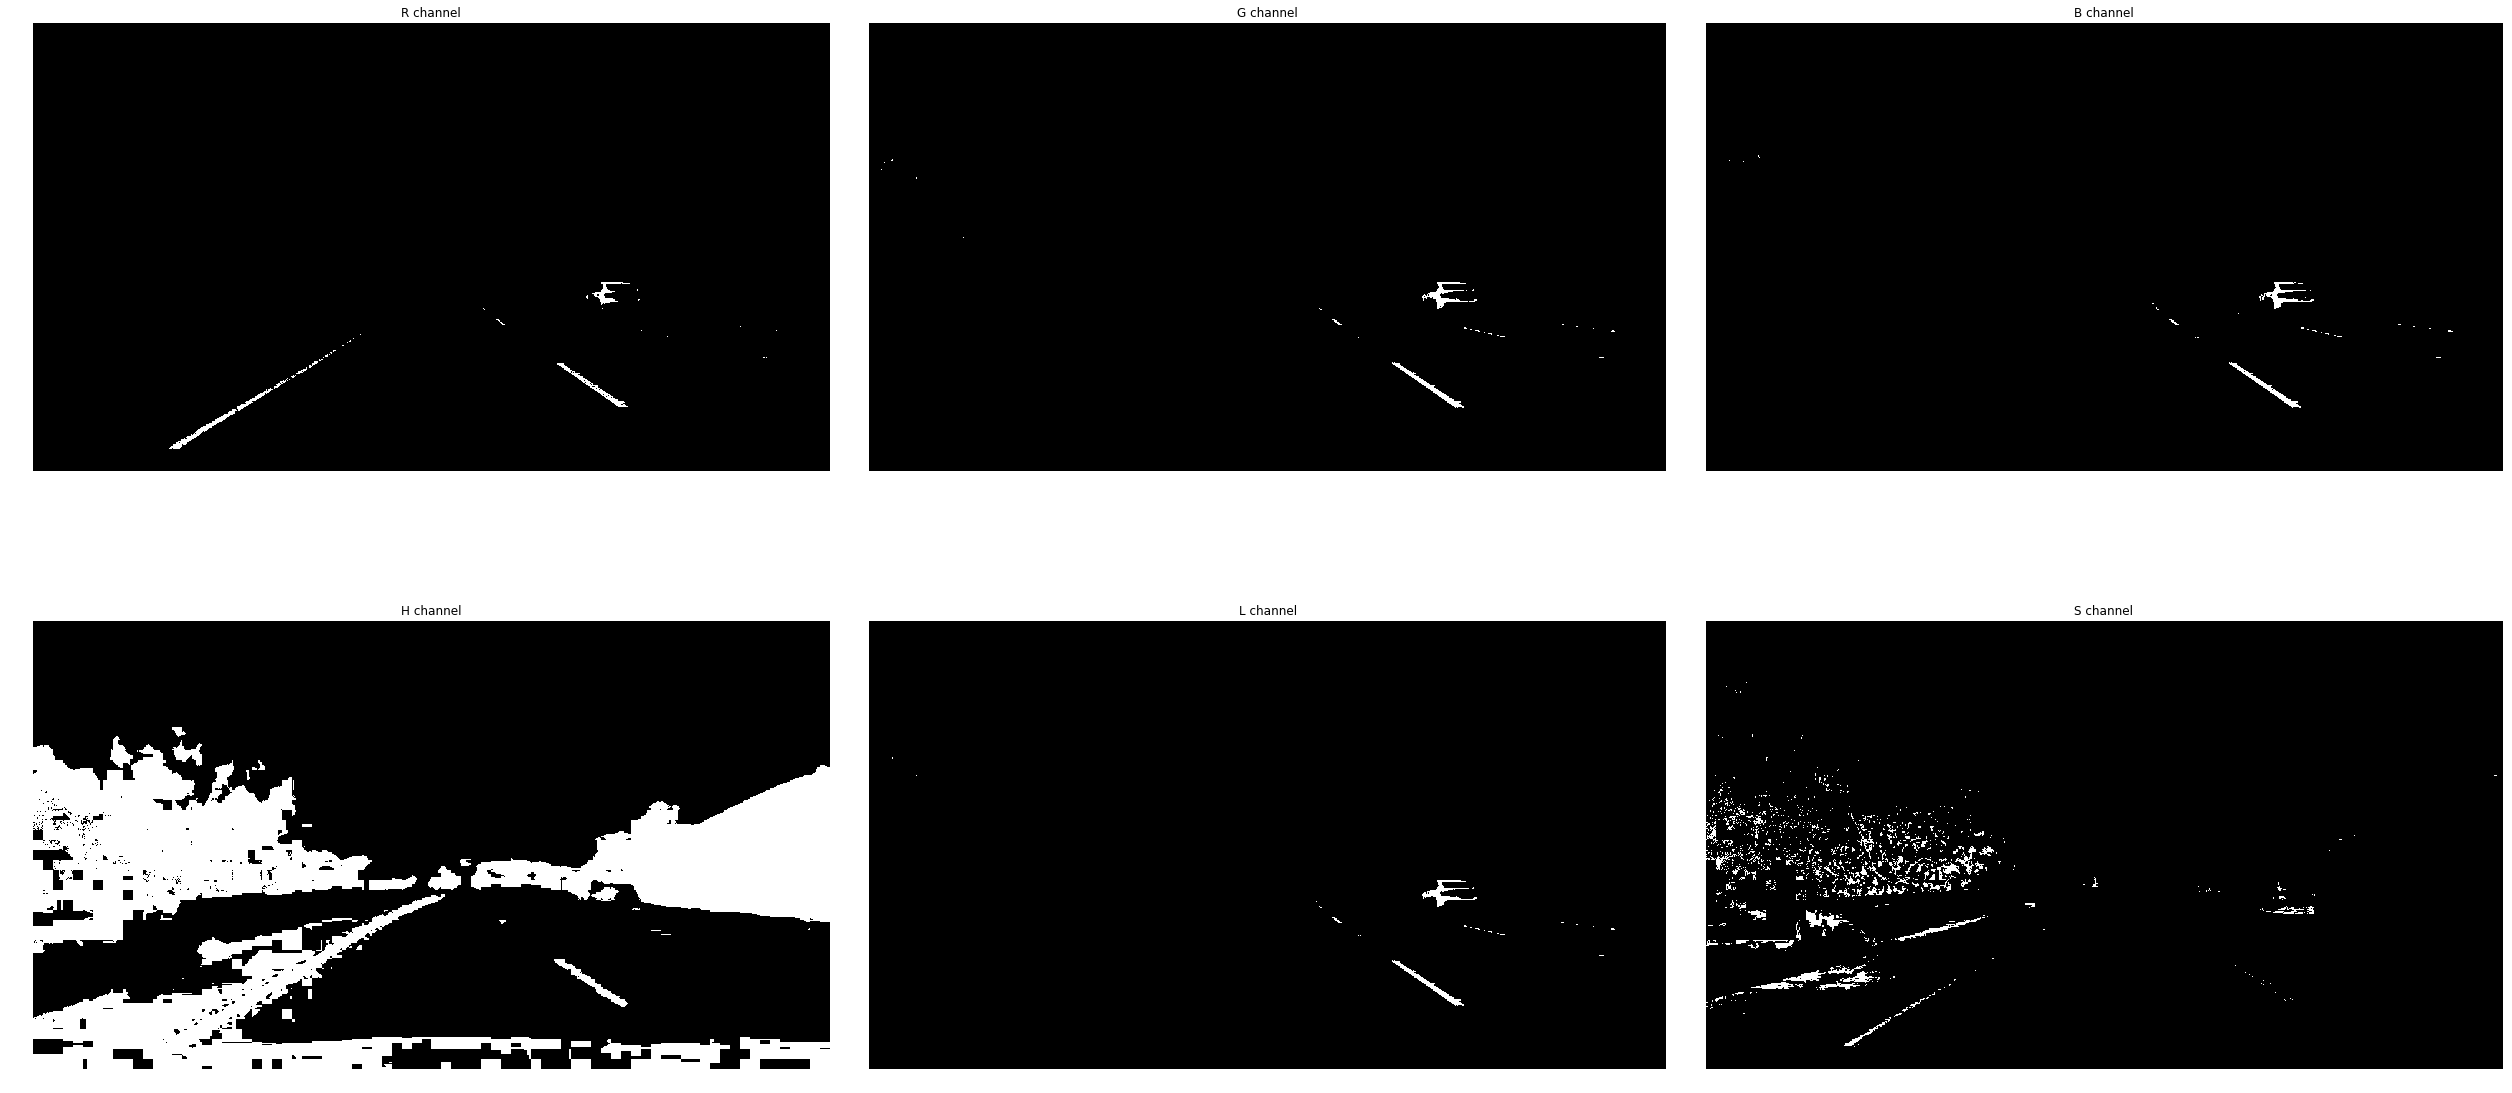

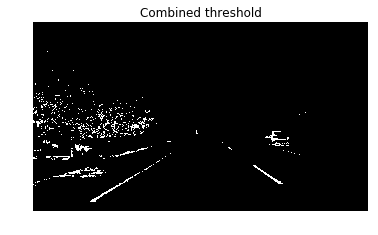

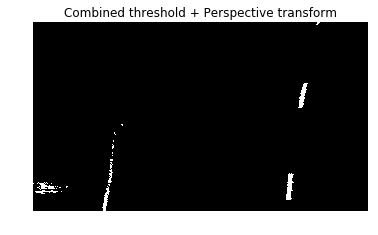

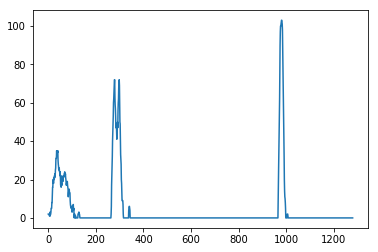

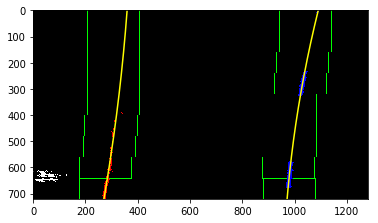

In [14]:
debug_frame('./debug/frame000623.jpg')

(-0.5, 1279.5, 719.5, -0.5)

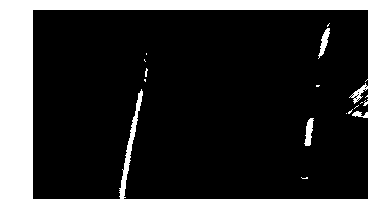

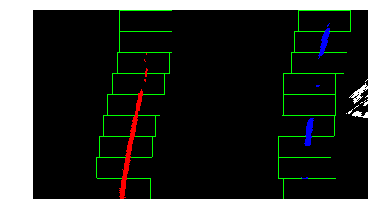

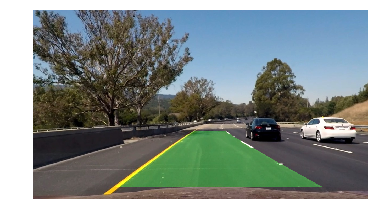

In [15]:

l_Line = Line()
r_Line = Line()

test_img_fname = './test_images/test6.jpg'

test_img = cv2.imread(test_img_fname)

img_with_lane, binary_warped, line_fit_img = find_lane_pipeline(test_img)
img_with_lane = cv2.cvtColor(img_with_lane, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots()
axes.imshow(binary_warped, cmap='gray')
axes.axis('off')

fig, axes = plt.subplots()
axes.imshow(line_fit_img, cmap='gray')
axes.axis('off')

fig, axes = plt.subplots()
axes.imshow(img_with_lane)
axes.axis('off')

# result, left_fitx, right_fitx, ploty = line_fit_lane_from_prev(binary_warped, left_fit, right_fit)


# plt.imshow(result)
# plt.plot(left_fitx, ploty, color='yellow')
# plt.plot(right_fitx, ploty, color='yellow')
# plt.xlim(0, 1280)
# plt.ylim(720, 0)


(-0.5, 1279.5, 719.5, -0.5)

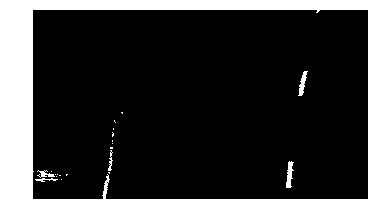

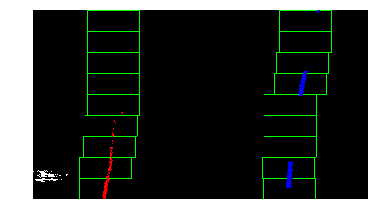

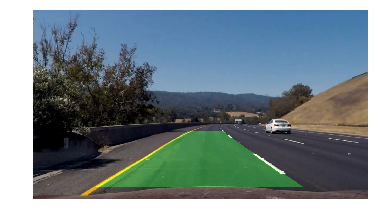

In [16]:

l_Line = Line()
r_Line = Line()

frame1 = cv2.imread('./debug/frame000623.jpg')
# frame2 = cv2.imread('./debug/frame000568.jpg')
# frame3 = cv2.imread('./debug/frame000002.jpg')


img_with_lane, binary_warped, line_fit_img = find_lane_pipeline(frame1)
img_with_lane = cv2.cvtColor(img_with_lane, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots()
axes.imshow(binary_warped, cmap='gray')
axes.axis('off')

fig, axes = plt.subplots()
axes.imshow(line_fit_img, cmap='gray')
axes.axis('off')

fig, axes = plt.subplots()
axes.imshow(img_with_lane)
axes.axis('off')



# img_with_lane, binary_warped, line_fit_img = find_lane_pipeline(frame2)
# img_with_lane = cv2.cvtColor(img_with_lane, cv2.COLOR_BGR2RGB)

# fig, axes = plt.subplots()
# axes.imshow(binary_warped, cmap='gray')
# axes.axis('off')

# fig, axes = plt.subplots()
# axes.imshow(line_fit_img, cmap='gray')
# axes.axis('off')


# fig, axes = plt.subplots()
# axes.imshow(img_with_lane)
# axes.axis('off')



# img_with_lane, binary_warped, line_fit_img = find_lane_pipeline(frame3)
# img_with_lane = cv2.cvtColor(img_with_lane, cv2.COLOR_BGR2RGB)

# fig, axes = plt.subplots()
# axes.imshow(binary_warped, cmap='gray')
# axes.axis('off')

# fig, axes = plt.subplots()
# axes.imshow(line_fit_img, cmap='gray')
# axes.axis('off')


# fig, axes = plt.subplots()
# axes.imshow(img_with_lane)
# axes.axis('off')



In [17]:
l_Line = Line()
r_Line = Line()

video_output = './output/project_video_out.mp4'
clip = VideoFileClip('./project_video.mp4')
challenge_clip = clip.fl_image(process_image)
%time challenge_clip.write_videofile(video_output, audio=False)



[MoviePy] >>>> Building video ./output/project_video_out.mp4
[MoviePy] Writing video ./output/project_video_out.mp4


100%|█████████▉| 1260/1261 [01:44<00:00, 12.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output/project_video_out.mp4 

Wall time: 1min 45s


In [18]:
clip = VideoFileClip('./output/project_video_out.mp4')
clip.write_images_sequence('./debug2/frame%06d.jpg')


[MoviePy] Writing frames ./debug2/frame%06d.jpg.

1260it [00:31, 39.41it/s]            


[MoviePy]: Done writing frames ./debug2/frame%06d.jpg.



['./debug2/frame000000.jpg',
 './debug2/frame000001.jpg',
 './debug2/frame000002.jpg',
 './debug2/frame000003.jpg',
 './debug2/frame000004.jpg',
 './debug2/frame000005.jpg',
 './debug2/frame000006.jpg',
 './debug2/frame000007.jpg',
 './debug2/frame000008.jpg',
 './debug2/frame000009.jpg',
 './debug2/frame000010.jpg',
 './debug2/frame000011.jpg',
 './debug2/frame000012.jpg',
 './debug2/frame000013.jpg',
 './debug2/frame000014.jpg',
 './debug2/frame000015.jpg',
 './debug2/frame000016.jpg',
 './debug2/frame000017.jpg',
 './debug2/frame000018.jpg',
 './debug2/frame000019.jpg',
 './debug2/frame000020.jpg',
 './debug2/frame000021.jpg',
 './debug2/frame000022.jpg',
 './debug2/frame000023.jpg',
 './debug2/frame000024.jpg',
 './debug2/frame000025.jpg',
 './debug2/frame000026.jpg',
 './debug2/frame000027.jpg',
 './debug2/frame000028.jpg',
 './debug2/frame000029.jpg',
 './debug2/frame000030.jpg',
 './debug2/frame000031.jpg',
 './debug2/frame000032.jpg',
 './debug2/frame000033.jpg',
 './debug2/fra